In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 2:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0:2])
    return np.array(dataX), np.array(dataY)

In [5]:
input_file="database.csv"

In [6]:
df = pd.read_csv(input_file)

In [7]:
df.head(15)


,X,Y,timestamp,anch0,anch1,anch2,anch3
0,4.409887,5.438117,142.8,5612.0,1999.0,NaN,4998.0
1,4.423119,5.441662,142.9,5609.0,2028.0,NaN,4959.0
2,4.437321,5.445468,143.0,5623.0,2007.0,NaN,5012.0
3,4.452115,5.449432,143.1,5658.0,2006.0,NaN,4958.0
4,4.467267,5.453492,143.2,5601.0,1991.0,NaN,5014.0
5,4.482638,5.457610,143.3,5588.0,1979.0,NaN,5004.0
6,4.498141,5.461764,143.4,5602.0,2005.0,NaN,5029.0
7,4.513726,5.465940,143.5,5603.0,2010.0,NaN,5045.0
8,4.529359,5.470129,143.6,5600.0,2022.0,NaN,5046.0
9,4.545023,5.474326,143.7,5601.0,1964.0,NaN,5184.0


In [24]:

dataset = df[["X","Y","anch0","anch1","anch2","anch3"]].fillna(-1).values
np.random.seed(5)
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train = dataset[:train_size,:]
test  = dataset[train_size:len(dataset),:]
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)


In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [10]:
hi = series_to_supervised(dataset,30)
l = ["var{}(t-{})".format(i,j) for j in range(30,0,-1) for i in range(1,7)]
l1 =[]
for j in range(30,0,-1):
    for i in range(1,7):
        if (not(i==1)and not(i==2)):
            l1.append("var{}(t-{})".format(i,j))
        
l1.append("var1(t)")
l1.append("var2(t)")
l1
f=hi[l1]
g=f.values.reshape((f.shape[0],1,f.shape[1]),)
g.shape

datas = f.values
train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
scaler = MinMaxScaler(feature_range=(0, 1))
train = datas[:train_size,:]
test  = datas[train_size:len(datas),:]
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)
trainX,trainY = train[:,:-2],train[:,120:122]
testX,testY = test[:,:-2],test[:,120:122]


In [12]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))


In [25]:
look_back=30
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

In [26]:
#t=trainX.reshape((trainX.shape[0],30,4))
trainX.shape

(5940, 30, 4)

In [27]:
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=32,validation_split=0.1, verbose=1)

Epoch 1/50
168/168 [==============================] - 3s 11ms/step - loss: 0.0469 - val_loss: 0.0327
Epoch 2/50
168/168 [==============================] - 2s 9ms/step - loss: 0.0176 - val_loss: 0.0139
Epoch 3/50
168/168 [==============================] - 2s 9ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 4/50
168/168 [==============================] - 2s 9ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 5/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 6/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 7/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 9/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 10/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0043 - val_loss:

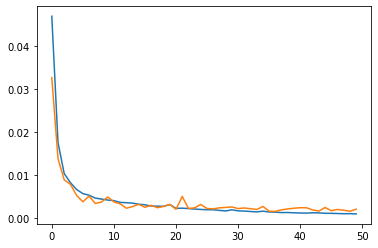

In [28]:
plt.plot(history.history["loss"],label = "training loss")
plt.plot(history.history["val_loss"],label = "val training loss")

In [61]:
l = [5361,2436,6748
,-1]
l
a = np.array(l)
a = a.reshape((-1,1))
b = scaler.fit_transform(a)
a = a.reshape(-1,1,4)
m = model.predict(a)
x = m.reshape((-1,1))
x

array([[0.7401575 ],
       [0.03722107]], dtype=float32)

In [67]:
test_size = len(dataset) - train_size

In [68]:
len(dataX)

487